In [100]:
import sys
sys.path.append("../code/")

from importlib import reload  
import lib_LinearAlgebra
import util_ElasticNet
import lib_ElasticNet
import lib_Checker
lib_LinearAlgebra = reload(lib_LinearAlgebra)
util_ElasticNet = reload(util_ElasticNet)
lib_ElasticNet = reload(lib_ElasticNet)
lib_Checker = reload(lib_Checker)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py

# Simulate data

In [101]:
n = 1000
k = 2000
n_outcome = 4
kcovar = 2
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome]) / 10
beta[5:, :] = 0
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([0, 0, 0, 0])  # [230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts

In [102]:
# with h5py.File('debug_en_tmp.hdf5', 'w') as f:
#     f.create_dataset('x', data = x)
#     f.create_dataset('y', data = y)
#     f.create_dataset('covar', data = covar)
#     f.create_dataset('beta', data = beta)
#     f.create_dataset('bcovar', data = bcovar)

In [103]:
# with h5py.File('debug_en_tmp.hdf5', 'r') as f:
#     x = f['x'][:]
#     y = f['y'][:]
#     covar = f['covar'][:]
#     beta = f['beta'][:]
#     bcovar = f['bcovar'][:]

In [104]:
# beta

Pack it as a dataset.

In [105]:
train_prop = 0.8
ntrain = int(n * train_prop)
train_batch = 512 # ntrain

In [106]:
dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset_train = dataset.take(ntrain)
dataset = dataset.skip(ntrain)
dataset_train = dataset_train.batch(train_batch)  #.repeat(200)
dataset_valid = dataset

In [107]:
x

array([[ 0.44277821, -1.50778783,  0.8830793 , ...,  0.55440938,
         0.86121788, -1.07745925],
       [ 0.8879341 , -1.69310624,  1.17237292, ..., -0.35279953,
        -0.27612556, -0.8382072 ],
       [ 0.38494483, -1.03757488, -0.36982408, ..., -1.94869928,
        -0.05979106,  0.10430709],
       ...,
       [ 1.21974401,  0.92681949, -1.1395799 , ...,  0.43367492,
         0.167459  ,  0.50563056],
       [-1.42303881,  0.54651068, -0.40871343, ..., -0.3852914 ,
        -2.03220501,  1.06389085],
       [-1.23721433, -0.10983576,  0.25969971, ..., -0.62438852,
         1.12308831,  0.47349327]])

Create the data scheme for loading x, y, and covariates.

In [108]:
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset_train, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0], 
    covariate_indice = [4, 5]
)

In [109]:
data_scheme.num_predictors

2000

Load validation data into memory.

In [110]:
for ele in dataset_valid.batch(10000):
    xvalid, yvalid = data_scheme.get_data_matrix(ele)
    yvalid = yvalid[:, 0][:, np.newaxis]
    break

# Run elastic net in crappy way

In [111]:
# Moved to lib_Checker.py
# import functools
# def my_stat_fun(np_1dim_array):
#     return np.mean(np_1dim_array)
# def diff_stop_rule(summary, threshold):
#     n = len(summary)
#     if n >= 2:
#         return (summary[n - 2] - summary[n - 1]) / max(abs(summary[n - 2]), abs(summary[n - 1])) < threshold
#     else:
#         return False
# my_stop_rule = functools.partial(diff_stop_rule, threshold = 1e-4)
# class Checker:
#     def __init__(self, sample_size, batch_size, stat_fun, stop_rule):
#         self.sample_size = sample_size
#         self.batch_size = batch_size
#         self.nbatch = self._get_nbatch()
#         self.iter_counter = 0
#         self.epoch_counter = 0
#         self.criteria_raw = []
#         self.criteria_summary = []
#         self.stat_fun = stat_fun
#         self.stop_rule = stop_rule
#         # internal state for current epoch
#         self._criteria_curr = self._empty_criteria_curr()  
#         self._iter_in_epoch_counter = 0
#     def update(self, step_size = 1):
#         '''
#         update the internal states and return -1 if still in the same epoch or 0 if update epoch
#         '''
#         self.iter_counter += step_size
#         epoch_now = self._get_curr_epoch()
#         if epoch_now == self.epoch_counter:
#             self._iter_in_epoch_counter += 1
#             return -1
#         elif epoch_now == self.epoch_counter + 1:
#             self._iter_in_epoch_counter = 0
#             self.epoch_counter += 1
#             return 0
#     def record(self, update_return, criteria):
#         '''
#         it should only be run after running update
#         '''
#         self.criteria_raw.append([self.iter_counter, self.epoch_counter, criteria])
#         self._criteria_curr[self._iter_in_epoch_counter] = criteria
#         if update_return == -1:
#             pass
#         elif update_return == 0:
#             self.criteria_summary.append(self.stat_fun(self._criteria_curr))
#             self._criteria_curr = self._empty_criteria_curr()
#             return 0
#     def ifstop(self):
#         return self.stop_rule(self.criteria_summary)
#     def _empty_criteria_curr(self):
#         return np.empty((self.nbatch, ))
#     def _get_nbatch(self):
#         div = int(self.sample_size / self.batch_size) 
#         if self.sample_size % self.batch_size == 0:
#             return div
#         else:
#             return div + 1
#     def _get_curr_epoch(self):
#         return int(self.iter_counter / self.sample_size)

In [112]:
import functools
my_stop_rule = functools.partial(lib_Checker.diff_stop_rule, threshold = 1e-4)

In [113]:
ntrain

800

In [114]:
alpha = 0.5
learning_rate = 0.05
nx = data_scheme.get_num_covariate() + data_scheme.get_num_predictor()
# model
model_lseq = lib_ElasticNet.ElasticNet(nx, alpha, 0)
# lambda seq
lambda_max = util_ElasticNet.get_lambda_max(model_lseq, xvalid, yvalid) * 2
lambda_seq = util_ElasticNet.get_lambda_sequence(lambda_max, lambda_max / 1e3, 100)
# update rule
updater = lib_ElasticNet.ProximalUpdater(learning_rate)
n = 0
betahat = np.empty((beta.shape[0], len(lambda_seq)))
path = []
counter = 0
for lambda_i in lambda_seq:
    print('lambda = {}'.format(lambda_i))
    model_lseq.update_lambda(lambda_i)
    i = 0
    checker = lib_Checker.Checker(ntrain, train_batch, lib_Checker.my_stat_fun, my_stop_rule)
    for ele in data_scheme.dataset:
        x, y = data_scheme.get_data_matrix(ele)
        step_size = x.shape[0]
        if i % 100 == 0:
            print('i = {}, model1 = {}'.format(i, model_lseq.objective(x, y)[0]))
        i += 1
        n += 1
        obj, loss = updater.proximal_train_step(model_lseq, x, y)
        update_status = checker.update(step_size)
        if update_status == 0:
            vloss = model_lseq.objective(x, y)[0]
            checker.record(update_status, vloss)
            if checker.ifstop() == True:
                break
#             print('checker ifstop = {}'.format(checker.ifstop()))
    betahat[:, counter] = model_lseq.A[:beta.shape[0], 0]
    path.append(np.array(checker.criteria_summary))
    counter += 1

lambda = 15.291495577071368
i = 0, model1 = 8.712570190429688
lambda = 14.260899940208578
i = 0, model1 = 8.385232925415039
lambda = 13.299763000918386
i = 0, model1 = 8.168700218200684
lambda = 12.403403475391794
i = 0, model1 = 8.025202751159668
lambda = 11.56745558268503
i = 0, model1 = 7.929896831512451
lambda = 10.787847780882133
i = 0, model1 = 7.866428375244141
lambda = 10.06078293636897
i = 0, model1 = 7.824026584625244
lambda = 9.38271982963188
i = 0, model1 = 7.795590400695801
lambda = 8.750355907503563
i = 0, model1 = 7.776435375213623
lambda = 8.160611197849933
i = 0, model1 = 7.763463973999023
lambda = 7.610613308353208
i = 0, model1 = 7.754626274108887
lambda = 7.0976834363268555
i = 0, model1 = 7.751045227050781
lambda = 6.6193233214222085
i = 0, model1 = 7.747461318969727
lambda = 6.17320307767896
i = 0, model1 = 7.741123199462891
lambda = 5.757149845654787
i = 0, model1 = 7.731244087219238
lambda = 5.369137209363427
i = 0, model1 = 7.71830940246582
lambda = 5.007275326

In [115]:
tmp = path[0]
for i in range(1, len(path)):
    tmp = np.concatenate((tmp, path[i]), axis = 0)
# path = np.reshape(tmp, newshape = tmp.shape[0] * tmp.shape[1])

In [116]:
path[0].shape

(1,)

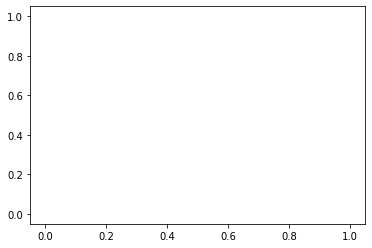

In [117]:
plt.plot(tmp[400:])

In [118]:
betahat[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

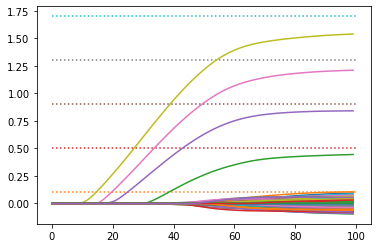

In [119]:
fig, aes = plt.subplots()
for i in range(betahat.shape[0]):
    aes.plot(betahat[i, :])
    if beta[i, 0] != 0:
        aes.plot([0, 100], [beta[i, 0], beta[i, 0]], ':')
# plt.plot(betahat[0,:])
# plt.plot(betahat[10,:])
# plt.plot(betahat[9,:])
# plt.plot(betahat[2,:])
# plt.plot(betahat[1,:])
# plt.plot(betahat[4,:])
# plt.plot(betahat[3,:])

In [120]:
path

[array([4.7304368]),
 array([4.63099861]),
 array([4.56640053]),
 array([4.52453947]),
 array([4.4974966]),
 array([4.48009586]),
 array([4.46895504]),
 array([4.46187115]),
 array([4.45740509]),
 array([4.45462179]),
 array([4.45251274]),
 array([4.44877005]),
 array([4.44246912]),
 array([4.43245983]),
 array([4.41912174]),
 array([4.40169334]),
 array([4.37932253]),
 array([4.3501339]),
 array([4.31390619]),
 array([4.2708106]),
 array([4.22133589]),
 array([4.1653471]),
 array([4.10300303]),
 array([4.03501034]),
 array([3.96203709]),
 array([3.88468933]),
 array([3.80353045]),
 array([3.71909595]),
 array([3.63189697]),
 array([3.54242039]),
 array([3.4511385]),
 array([3.35862589]),
 array([3.26495218]),
 array([3.17034554]),
 array([3.07513738]),
 array([2.97963285]),
 array([2.88421965]),
 array([2.78919888]),
 array([2.69481587]),
 array([2.60133457]),
 array([2.50894356]),
 array([2.41779947]),
 array([2.32810879]),
 array([2.24001598]),
 array([2.15365028]),
 array([2.069159

# Test ElasticNetEstimator (allow multiple y trained at once)

In [121]:
import lib_LinearAlgebra
lib_LinearAlgebra = reload(lib_LinearAlgebra)
import logging, sys

# initialize multiple y
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset_train, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1], 
    covariate_indice = [4, 5]
)
ny = len(data_scheme.outcome_indice)

# configing util
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr, 
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)

alpha = 0.5
learning_rate = 0.05
nlambda = 50
lambda_init_dict = {
    'data_init': None, 
    'prefactor_of_lambda_max': 2,
    'lambda_max_over_lambda_min': 1e3,
    'nlambda': nlambda
}
my_stop_rule = functools.partial(lib_Checker.diff_stop_rule, threshold = 1e-4)
# updater = lib_ElasticNet.ProximalUpdater(learning_rate)
elastic_net_estimator = lib_LinearAlgebra.ElasticNetEstimator(
    data_scheme,
    alpha,
    normalizer = True,
    learning_rate = learning_rate,
    lambda_init_dict = lambda_init_dict
)
checker_list = [ 
    lib_Checker.Checker(ntrain, train_batch, lib_Checker.my_stat_fun, my_stop_rule) 
    for i in range(ny)
]

elastic_net_estimator.solve(checker_list, 100, logging = logging)

2020-01-30 09:57:42 PM  start norm
2020-01-30 09:57:42 PM  end norm
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 1 epoch
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 2 epoch
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 3 epoch
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 4 epoch
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 5 epoch
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 6 epoch
2020-01-30 09:57:42 PM  Gone through outer loop 1 / 50 and inner loop 7 epoch
2020-01-30 09:57:43 PM  Gone through outer loop 1 / 50 and inner loop 8 epoch
2020-01-30 09:57:43 PM  Gone through outer loop 1 / 50 and inner loop 9 epoch
2020-01-30 09:57:43 PM  Gone through outer loop 1 / 50 and inner loop 10 epoch
2020-01-30 09:57:43 PM  Gone through outer loop 1 / 50 and inner loop 11 epoch
2020-01-30 09:57:43 PM  Gone through outer loop 1 / 50 and inner loop 12

2020-01-30 09:57:47 PM  Gone through outer loop 18 / 50 and inner loop 7 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 18 / 50 and inner loop 8 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 18 / 50 and inner loop 9 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 1 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 2 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 3 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 4 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 5 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 6 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 7 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 8 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 19 / 50 and inner loop 9 epoch
2020-01-30 09:57:48 PM  Gone through outer loop 20 /

2020-01-30 09:57:53 PM  Gone through outer loop 48 / 50 and inner loop 2 epoch
2020-01-30 09:57:53 PM  Gone through outer loop 49 / 50 and inner loop 1 epoch
2020-01-30 09:57:53 PM  Gone through outer loop 49 / 50 and inner loop 2 epoch
2020-01-30 09:57:53 PM  Gone through outer loop 50 / 50 and inner loop 1 epoch
2020-01-30 09:57:53 PM  Gone through outer loop 50 / 50 and inner loop 2 epoch


{'obj': [array([4.7304368 , 4.63099861, 4.56640053, 4.52453947, 4.4974966 ,
         4.48009586, 4.46895504, 4.46187115, 4.45740509, 4.45462179,
         4.45291471, 4.45189142, 4.45129871, 4.45097208, 4.45081043,
         4.45074558, 4.45073652, 4.45075798, 4.45079422, 4.45083618,
         4.45087767, 4.45091724, 4.449471  , 4.44950056, 4.43906021,
         4.43721199, 4.43665218, 4.43646765, 4.41125917, 4.40819216,
         4.40722275, 4.4068737 , 4.35854197, 4.3533597 , 4.3515811 ,
         4.35089588, 4.35061169, 4.27711344, 4.27056265, 4.26808453,
         4.26704502, 4.26657772, 4.2663579 , 4.16895866, 4.16093588,
         4.15758324, 4.1560564 , 4.15531588, 4.15494299, 4.03515387,
         4.02636147, 4.02243519, 4.02054644, 4.01958275, 4.01907206,
         4.01879311, 3.88058162, 3.87195921, 3.86787415, 3.86581039,
         3.86471081, 3.86410189, 3.86375499, 3.71105719, 3.70267773,
         3.69850445, 3.69630671, 3.6950922 , 3.69439554, 3.69398451,
         3.69373798, 3.5302

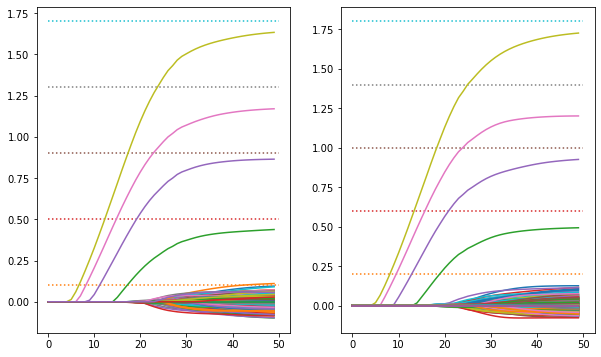

In [122]:
fig, aes = plt.subplots(ncols = ny, nrows = 1, figsize = (10, 6))
for yi in range(ny):
    for i in range(elastic_net_estimator.beta_hat_path.shape[0]):
        aes[yi].plot(elastic_net_estimator.beta_hat_path[i, yi, :])
        if beta[i, yi] != 0:
            aes[yi].plot([0, nlambda], [beta[i, yi], beta[i, yi]], ':')

In [123]:
elastic_net_estimator.beta_hat_path.shape

TensorShape([2000, 2, 50])

In [124]:
out = elastic_net_estimator.predict_x(dataset_valid.batch(512), elastic_net_estimator.beta_hat_path)

(200, 2, 50)


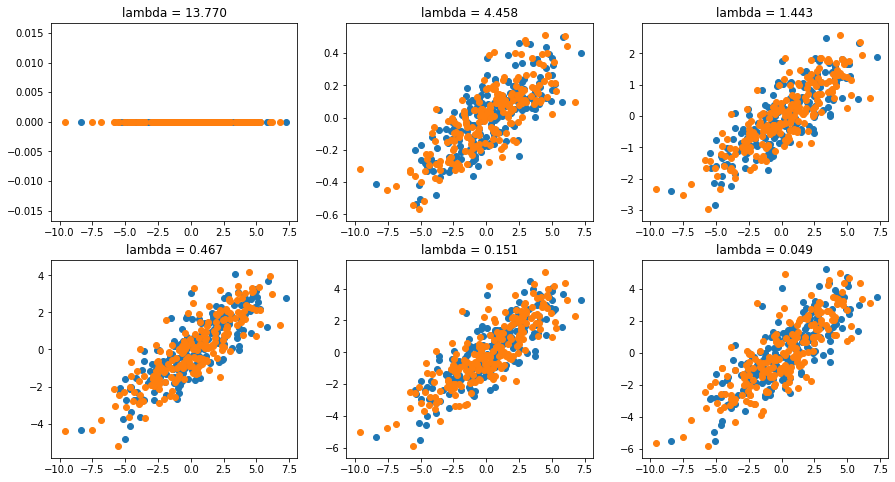

In [125]:
fig, aes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
for i in range(2):
    for j in range(3):
        idx = (i * 3 + j) * 8
        if idx < len(elastic_net_estimator.lambda_seq[0]):
            aes[i][j].scatter(out['y'][:,0], out['y_pred_from_x'][:, :, idx][:,0])
            aes[i][j].scatter(out['y'][:,1], out['y_pred_from_x'][:, :, idx][:,1])
            aes[i][j].set_title('lambda = ' + "{:.3f}".format(np.array(elastic_net_estimator.lambda_seq)[0, idx]))


In [126]:
for x, y in data_scheme.dataset:
#     x, y = data_scheme.get_data_matrix(ele)
    print(x.shape)
    print(y.shape)

(512, 2000)
(512, 6)
(288, 2000)
(288, 6)


# Test line search

In [139]:
import lib_LinearAlgebra
lib_LinearAlgebra = reload(lib_LinearAlgebra)
import logging, sys

# initialize multiple y
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset_train, 
    X_index = 0,
    Y_index = 1,
    outcome_indice = [0, 1], 
    covariate_indice = [4, 5]
)
ny = len(data_scheme.outcome_indice)

# configing util
logging.basicConfig(
    level = logging.INFO, 
    stream = sys.stderr, 
    format = '%(asctime)s  %(message)s',
    datefmt = '%Y-%m-%d %I:%M:%S %p'
)

alpha = 0.5
learning_rate = 0.05
nlambda = 50
lambda_init_dict = {
    'data_init': None, 
    'prefactor_of_lambda_max': 2,
    'lambda_max_over_lambda_min': 1e3,
    'nlambda': nlambda
}
my_stop_rule = functools.partial(lib_Checker.diff_stop_rule, threshold = 1e-4)
updater = lib_ElasticNet.ProximalUpdater(learning_rate = learning_rate, line_search = True)
update_dic = {
    'updater': updater,
    'update_fun': updater.proximal_train_step
}
elastic_net_estimator = lib_LinearAlgebra.ElasticNetEstimator(
    data_scheme,
    alpha,
    normalizer = True,
    learning_rate = learning_rate,
    lambda_init_dict = lambda_init_dict,
    updater = update_dic
)
checker_list = [ 
    lib_Checker.Checker(ntrain, train_batch, lib_Checker.my_stat_fun, my_stop_rule) 
    for i in range(ny)
]

elastic_net_estimator.solve(checker_list, 100, logging = logging)


2020-01-30 10:01:42 PM  start norm
2020-01-30 10:01:42 PM  end norm
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 1 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 2 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 3 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 4 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 5 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 6 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 7 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 8 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 9 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 10 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 11 epoch
2020-01-30 10:01:43 PM  Gone through outer loop 1 / 50 and inner loop 12

2020-01-30 10:01:51 PM  Gone through outer loop 18 / 50 and inner loop 7 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 18 / 50 and inner loop 8 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 18 / 50 and inner loop 9 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 1 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 2 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 3 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 4 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 5 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 6 epoch
2020-01-30 10:01:51 PM  Gone through outer loop 19 / 50 and inner loop 7 epoch
2020-01-30 10:01:52 PM  Gone through outer loop 19 / 50 and inner loop 8 epoch
2020-01-30 10:01:52 PM  Gone through outer loop 19 / 50 and inner loop 9 epoch
2020-01-30 10:01:52 PM  Gone through outer loop 20 /

2020-01-30 10:01:59 PM  Gone through outer loop 48 / 50 and inner loop 2 epoch
2020-01-30 10:01:59 PM  Gone through outer loop 49 / 50 and inner loop 1 epoch
2020-01-30 10:01:59 PM  Gone through outer loop 49 / 50 and inner loop 2 epoch
2020-01-30 10:01:59 PM  Gone through outer loop 50 / 50 and inner loop 1 epoch
2020-01-30 10:01:59 PM  Gone through outer loop 50 / 50 and inner loop 2 epoch


{'obj': [array([4.7304368 , 4.63099861, 4.56640053, 4.52453947, 4.4974966 ,
         4.48009586, 4.46895504, 4.46187115, 4.45740509, 4.45462179,
         4.45291471, 4.45189142, 4.45129871, 4.45097208, 4.45081043,
         4.45074558, 4.45073652, 4.45075798, 4.45079422, 4.45083618,
         4.45087767, 4.45091724, 4.449471  , 4.44950056, 4.43906021,
         4.43721199, 4.43665218, 4.43646765, 4.41125917, 4.40819216,
         4.40722275, 4.4068737 , 4.35854197, 4.3533597 , 4.3515811 ,
         4.35089588, 4.35061169, 4.27711344, 4.27056265, 4.26808453,
         4.26704502, 4.26657772, 4.2663579 , 4.16895866, 4.16093588,
         4.15758324, 4.1560564 , 4.15531588, 4.15494299, 4.03515387,
         4.02636147, 4.02243519, 4.02054644, 4.01958275, 4.01907206,
         4.01879311, 3.88058162, 3.87195921, 3.86787415, 3.86581039,
         3.86471081, 3.86410189, 3.86375499, 3.71105719, 3.70267773,
         3.69850445, 3.69630671, 3.6950922 , 3.69439554, 3.69398451,
         3.69373798, 3.5302

(200, 2, 50)


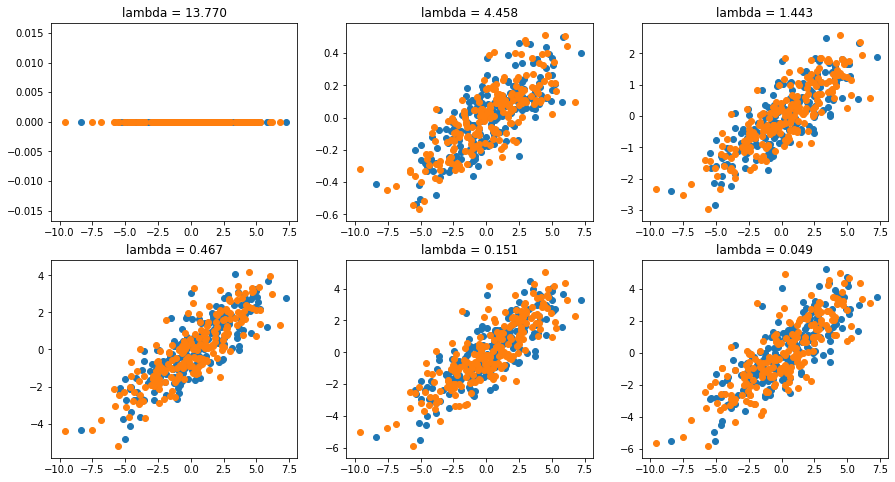

In [145]:
out = elastic_net_estimator.predict_x(dataset_valid.batch(512), elastic_net_estimator.beta_hat_path)
fig, aes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
for i in range(2):
    for j in range(3):
        idx = (i * 3 + j) * 8
        if idx < len(elastic_net_estimator.lambda_seq[0]):
            aes[i][j].scatter(out['y'][:,0], out['y_pred_from_x'][:, :, idx][:,0])
            aes[i][j].scatter(out['y'][:,1], out['y_pred_from_x'][:, :, idx][:,1])
            aes[i][j].set_title('lambda = ' + "{:.3f}".format(np.array(elastic_net_estimator.lambda_seq)[0, idx]))


# Test minimal save and load

In [141]:
import lib_LinearAlgebra
lib_LinearAlgebra = reload(lib_LinearAlgebra)
elastic_net_estimator.minimal_save('test_save.hdf5')

Saving lambda_seq
Saving beta_hat_path
Saving covar_hat_path
Saving intercept_path
Saving normalizer
Saving alpha
Saving data_scheme.dataset
Saving data_scheme.X_index
Saving data_scheme.Y_index
Saving data_scheme.outcome_indice
Saving data_scheme.covariate_indice
Saving data_scheme.num_predictors


In [142]:
loaded_estimator = lib_LinearAlgebra.ElasticNetEstimator('', None, minimal_load = True)

In [143]:
loaded_estimator.minimal_load('test_save.hdf5')

(200, 2, 50)


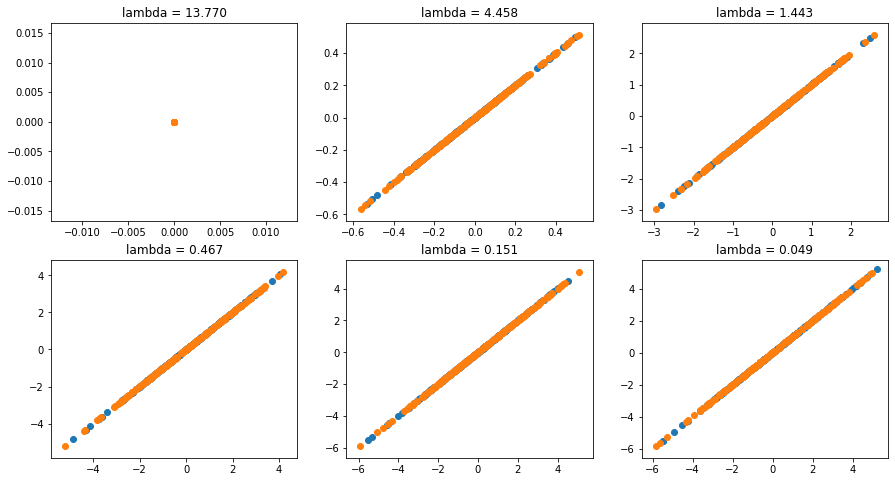

In [147]:
out2 = loaded_estimator.predict_x(dataset_valid.batch(512), loaded_estimator.beta_hat_path)
fig, aes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
for i in range(2):
    for j in range(3):
        idx = (i * 3 + j) * 8
        if idx < len(elastic_net_estimator.lambda_seq[0]):
            aes[i][j].scatter(out2['y_pred_from_x'][:, :, idx][:,0], out['y_pred_from_x'][:, :, idx][:,0])
            aes[i][j].scatter(out2['y_pred_from_x'][:, :, idx][:,1], out['y_pred_from_x'][:, :, idx][:,1])
            aes[i][j].set_title('lambda = ' + "{:.3f}".format(np.array(elastic_net_estimator.lambda_seq)[0, idx]))
